Exploratory analaysis of the filtered callsets.  We create a matrix whose rows are somatic SNVs.  Columns include: annotations from VCF files, clinical variables and variables specific to genomic regions. This latter class of variables contains information on chromatin state (from RoadMap Epigen Consortium), evolutionarily constrain, GWAS and CNV loci associated to schizophrenia...

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from bsmcalls import readVCF
from bsmcalls import individuals
from bsmcalls import preprocessing
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas.plotting as ppl
import re
import attila_utils
%matplotlib inline

In [2]:
plt.style.use('classic')

### Annotation of callsets

In [3]:
%%bash
~/projects/bsm/src/bsmcalls/readVCF.py -h
if false; then
# run script with default options
~/projects/bsm/src/bsmcalls/readVCF.py
fi

usage: readVCF.py [-h] [-d DIR] [-l VCFLIST]

optional arguments:
  -h, --help            show this help message and exit
  -d DIR, --dir DIR     main VCF directory
                        (/home/attila/projects/bsm/results/calls/)
  -l VCFLIST, --vcflist VCFLIST
                        list of samples and VCF files
                        (/big/results/bsm/calls/filtered-vcfs.tsv)


### Loading callsets

In [4]:
allcalls = individuals.get_data(merge=True, cleancalls=False)
allcalls

REF ALT    QUAL    FILTER/PASS  \
Individual ID Tissue  CHROM POS       Mutation                                  
CMC_MSSM_027  NeuN_pl 1     11973569  C/T        C   T   83.07   HC;PASS/PASS   
                            67324428  A/T        A   T  203.16   HC;PASS/PASS   
                            182008461 C/T        C   T  164.46   HC;PASS/PASS   
                            207598957 C/T        C   T  168.14   HC;PASS/PASS   
                            219342012 C/T        C   T   78.80   HC;PASS/PASS   
...                                             ..  ..     ...            ...   
CMC_MSSM_331  muscle  3     69166433  T/G        T   G   53.75      PASS/PASS   
                      6     36807240  C/T        C   T  147.44   HC;PASS/PASS   
                      12    86938406  T/G        T   G  194.65  EXT;PASS/PASS   
                      16    48114834  C/T        C   T  162.11   HC;PASS/PASS   
                      17    29109599  T/G        T   G  202.97  EXT;PASS/PASS   

                                                  FILTER/HC    FILTER/EXT  AC  \
Individual ID Tissue  CHROM POS       Mutation                                  
CMC_MSSM_027  NeuN_pl 1     11973569  C/T        HC;PASS/HC   HC;PASS/EXT   1   
                            67324428  A/T        HC;PASS/HC   HC;PASS/EXT   3   
                            182008461 C/T        HC;PASS/HC   HC;PASS/EXT   3   
                            207598957 C/T        HC;PASS/HC   HC;PASS/EXT   3   
                            219342012 C/T        HC;PASS/HC   HC;PASS/EXT   1   
...                                                     ...           ...  ..   
CMC_MSSM_331  muscle  3     69166433  T/G           PASS/HC      PASS/EXT   3   
                      6     36807240  C/T        HC;PASS/HC   HC;PASS/EXT   5   
                      12    86938406  T/G       EXT;PASS/HC  EXT;PASS/EXT   8   
                      16    48114834  C/T        HC;PASS/HC   HC;PASS/EXT   6   
                      17    29109599  T/G       EXT;PASS/HC  EXT;PASS/EXT   8   

                                                  AF  AN  BaseQRankSum  ...  \
Individual ID Tissue  CHROM POS       Mutation                          ...   
CMC_MSSM_027  NeuN_pl 1     11973569  C/T       0.02  50         0.517  ...   
                            67324428  A/T       0.06  50        -2.660  ...   
                            182008461 C/T       0.06  50         1.420  ...   
                            207598957 C/T       0.06  50         1.040  ...   
                            219342012 C/T       0.02  50         1.600  ...   
...                                              ...  ..           ...  ...   
CMC_MSSM_331  muscle  3     69166433  T/G       0.06  50        -0.883  ...   
                      6     36807240  C/T       0.10  50         2.950  ...   
                      12    86938406  T/G       0.16  50        -1.735  ...   
                      16    48114834  C/T       0.12  50         2.190  ...   
                      17    29109599  T/G       0.16  50        -2.923  ...   

                                                Antidepress  Lithium  Alcohol  \
Individual ID Tissue  CHROM POS       Mutation                                  
CMC_MSSM_027  NeuN_pl 1     11973569  C/T                 0        0        1   
                            67324428  A/T                 0        0        1   
                            182008461 C/T                 0        0        1   
                            207598957 C/T                 0        0        1   
                            219342012 C/T                 0        0        1   
...                                                     ...      ...      ...   
CMC_MSSM_331  muscle  3     69166433  T/G                 0        0        0   
                      6     36807240  C/T                 0        0        0   
                      12    86938406  T/G                 0        0        0   
                    

In [5]:
repr(list(allcalls.columns))

"['REF', 'ALT', 'QUAL', 'FILTER/PASS', 'FILTER/HC', 'FILTER/EXT', 'AC', 'AF', 'AN', 'BaseQRankSum', 'DP', 'DS', 'END', 'ExcessHet', 'FS', 'InbreedingCoeff', 'MLEAC', 'MLEAF', 'MQ', 'MQRankSum', 'NEGATIVE_TRAIN_SITE', 'POSITIVE_TRAIN_SITE', 'QD', 'RAW_MQandDP', 'ReadPosRankSum', 'SOR', 'VQSLOD', 'culprit', 'ChromatinState_DLPFC', 'szdbCNVcount', 'GWASpval', 'Institution', 'Reported Gender', 'Ethnicity', 'ageOfDeath', 'Brain Weight (in grams)', 'PMI (in hours)', 'Dx', 'Year of Autopsy', 'Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp', 'Antidepress', 'Lithium', 'Alcohol', 'Illicitsub', 'causeOfDeath', 'EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5']"

### Number of individuals and calls

In [6]:
s = allcalls.groupby(['Tissue', 'Dx', 'Individual ID']).size()
a = s.loc[s != 0].groupby(['Tissue', 'Dx']).size()
b = allcalls.groupby(['Tissue', 'Dx']).size()
nic = pd.DataFrame({'Individuals': a, 'Calls': b})
nic

Individuals  Calls
Tissue  Dx                         
NeuN_mn Control            0      0
        SCZ                1      1
NeuN_pl Control           25    895
        SCZ               61   2488
muscle  Control            3      6
        SCZ                2     21

In [7]:
def extract_nic(Dx, column):
    s = nic.loc[nic.index.get_level_values('Dx') == Dx, column]
    return(s)

extract_nic('SCZ', 'Calls')
#nic.loc[nic.index.get_level_values('Dx') == 'Control', 'Individuals']

Tissue   Dx 
NeuN_mn  SCZ       1
NeuN_pl  SCZ    2488
muscle   SCZ      21
Name: Calls, dtype: int64

['named-figure/num-indiv-calls-Dx.png', 'named-figure/num-indiv-calls-Dx.pdf']

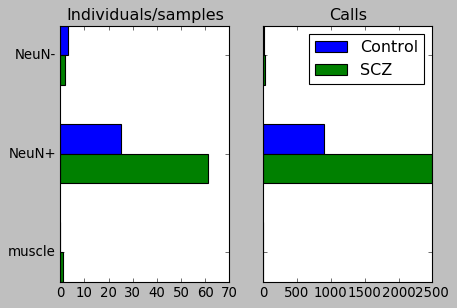

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
ticks = np.arange(0, 3)
height = 0.3
offset = height / 2
ax[0].barh(y=ticks + offset, width=extract_nic('Control', 'Individuals'), height=height, label='Control')
ax[0].barh(y=ticks - offset, width=extract_nic('SCZ', 'Individuals'), height=height, label='SCZ')
ax[0].set_title('Individuals/samples')
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(['muscle', 'NeuN+', 'NeuN-'])
ax[1].barh(y=ticks + offset, width=extract_nic('Control', 'Calls'), height=height, label='Control')
ax[1].barh(y=ticks - offset, width=extract_nic('SCZ', 'Calls'), height=height, label='SCZ')
ax[1].set_title('Calls')
ax[1].legend()
attila_utils.savefig(fig, 'num-indiv-calls-Dx')

## Looking at NeuN+ samples only

In [9]:
calls = allcalls.loc(axis=0)[:, 'NeuN_pl']

['named-figure/eCDF-calls.png', 'named-figure/eCDF-calls.pdf']

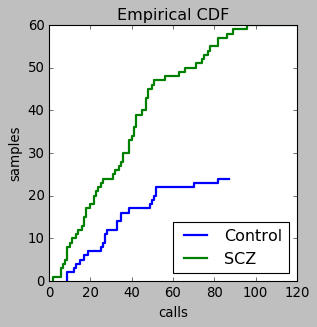

In [10]:
s = calls.groupby(['Dx', 'Individual ID']).size()
s = s[s != 0]
fig, ax = plt.subplots(figsize=(4, 4))
def foo(Dx):
    y = s.groupby('Dx').get_group(Dx).sort_values().values
    x = range(len(y))
    ax.step(y, x, label=Dx, linewidth=2)

foo('Control')
foo('SCZ')
ax.legend(loc='lower right')
ax.set_title('Empirical CDF')
ax.set_xlabel('calls')
ax.set_ylabel('samples')
ax.set_xlim(0, 120)
attila_utils.savefig(fig, 'eCDF-calls')

### Chromatin state in DLPFC

In [11]:
state_Dx = pd.crosstab(calls['ChromatinState_DLPFC'], calls['Dx'], margins=True)
state_Dx

Dx,Control,SCZ,All
ChromatinState_DLPFC,,,
TssA,9,51,60
TssAFlnk,4,16,20
TxFlnk,0,3,3
Tx,30,90,120
TxWk,118,336,454
EnhG,3,7,10
Enh,34,77,111
ZNF/Rpts,2,2,4
Het,10,28,38


No variants are observed in the following states:

In [12]:
set(readVCF.state15label.values()) - set(state_Dx.index)

{'BivFlnk', 'EnhBiv'}

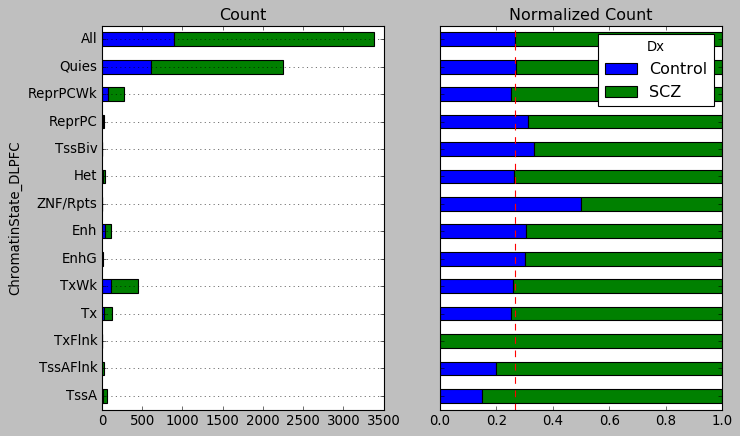

In [13]:
state_Dx_norm = pd.crosstab(calls['ChromatinState_DLPFC'], calls['Dx'], normalize='index', margins=True)
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
state_Dx[['Control', 'SCZ']].plot.barh(stacked=True, ax=ax[0], legend=False, title='Count')
ax[0].grid(True, axis='y')
ax[1].vlines(state_Dx_norm.loc['All', 'Control'], *ax[1].get_ylim(), colors='red', linestyles='dashed')
state_Dx_norm.plot.barh(stacked=True, ax=ax[1], title='Normalized Count')

### Comparison to Autism study by Walsh & Park labs

Findings on somatic variants in autistic vs control brains in the Walsh & Park labs

1. "We did not observe enrichment of overall sSNVs and validated mosaic indels in brain-active enhancers in ASD cases compared to controls; however, we did observe significant enrichment when assessing only sequences bearing active enhancer marks in a majority of brain epigenomes available for analysis (from Roadmap Epigenomics 39 ), reflecting those regions that are most likely to represent critical enhancers shared across individuals."
1. "Furthermore, genes with transcription start sites within 50kb of these shared brain-active enhancers (≥5 brain epigenomes with active enhancer status in the Roadmap data) with mosaic mutations were enriched for brain-specific expression, implying direct functional relevance of enhancer mutations"

Our preliminary analysis above suggests a different picture in Schizophrenia.  Altough we only looked included a single epigenome (the one corresponding to DLPFC) from the RoadMap study in this analysis there's not even a slight indication of an enrichment of enhancers in somatic variants in schizophrenic versus control brains.

The only tendency is the enrichment of transcription start sites (TssA and TssAFlnk) in SCZ somatic variants relative to Control.

### Allele frequency

(2.5, 0.5)

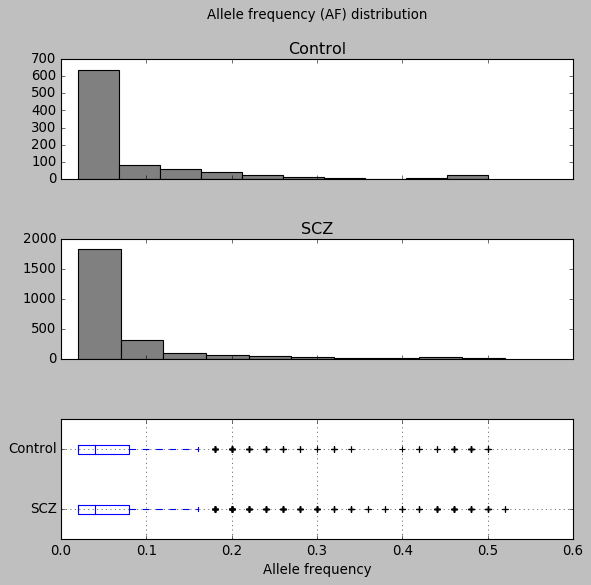

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
calls.hist(column='AF', by='Dx', ax=ax[0:2], grid=True, color='gray')
calls.boxplot('AF', by='Dx', vert=False, ax=ax[2], showfliers=True, color='black')
ax[2].set_xlabel('Allele frequency')
ax[2].set_title('')
fig.suptitle('Allele frequency (AF) distribution')
ax[2].set_ylim(2.5, 0.5)

### Schizophrenia CNVs

The `szdbCNVcount` variable shows the number of occurrence in [SZDB](http://www.szdb.org/) of a CNV---more precisely a single cytogenic band containing or contained in that CNV.  This information was taken from [this table](http://www.szdb.org/download/CNV.txt) in SZDB.  See the `2020-07-24-szdb` article in this notebook.

Text(0, 0.5, '# somatic variants')

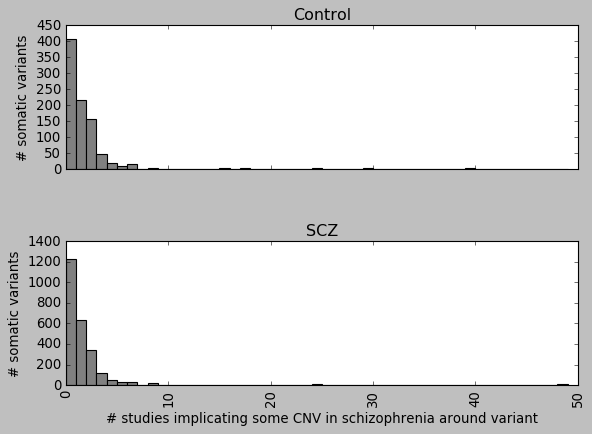

In [15]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
calls.hist(column='szdbCNVcount', by='Dx', ax=ax, grid=True, color='gray', bins=range(50))
ax[1].set_xlabel('# studies implicating some CNV in schizophrenia around variant')    
ax[0].set_ylabel('# somatic variants')
ax[1].set_ylabel('# somatic variants')

Text(0.5, 0.98, '# studies implicating some CNV in schizophrenia around variant')

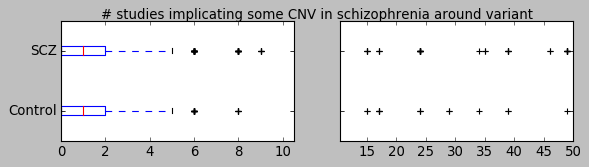

In [16]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 2))
def foo(ax):
    calls.boxplot('szdbCNVcount', by='Dx', vert=False, ax=ax, grid=False)
    ax.set_xlabel('')
    ax.set_title('')
    
foo(ax[0])
foo(ax[1])
ax[0].set_xlim([0, 10.5])
ax[1].set_xlim([10.5, 50])
fig.suptitle('# studies implicating some CNV in schizophrenia around variant')

In [17]:
gb = calls.groupby(['Dx', 'Individual ID', 'szdbCNVcount'])
s = gb.size()
s

Dx       Individual ID  szdbCNVcount
Control  CMC_MSSM_027   0               0
                        1               0
                        2               0
                        3               0
                        4               0
                                       ..
SCZ      CMC_PITT_118   34              0
                        35              0
                        39              0
                        46              0
                        49              0
Length: 3096, dtype: int64

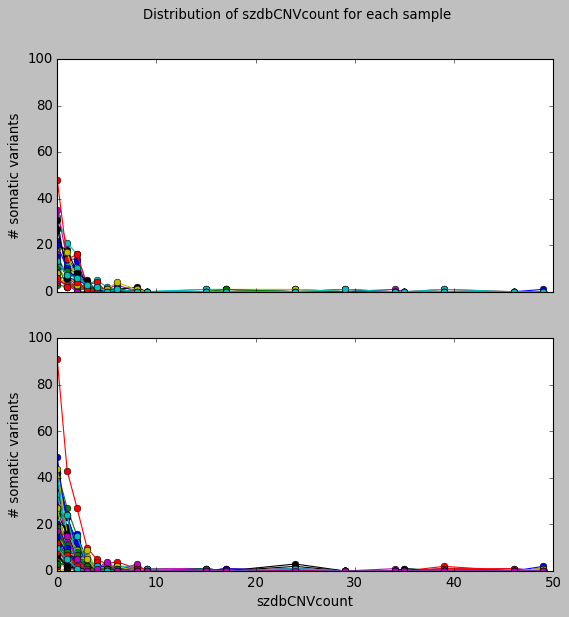

In [18]:
def boo(xlim=None):
    fig, ax = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(8, 8))
    multiix = calls.groupby(['Dx', 'Individual ID']).size().index
    mycolors = {'Control': 'blue', 'SCZ': 'green'}
    for ix in multiix:
        a = s.loc[ix]
        if a.any():
            Dx = ix[0]
            row = 0 if Dx == 'Control' else 1
            a.plot(marker='o', ax=ax[row], label=ix[1])
            ax[0].set_ylabel('# somatic variants')
            ax[1].set_ylabel('# somatic variants')
            fig.suptitle('Distribution of szdbCNVcount for each sample')
            if xlim is not None:
                ax[0].set_xlim(xlim)
    #ax[0].legend()
    #ax[1].legend()

boo()

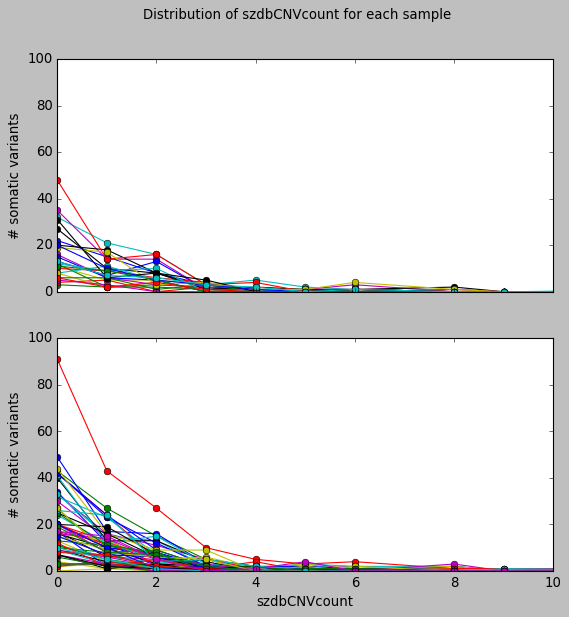

In [19]:
boo([0, 10])

### GWAS

The `GWASpval` variable is $-\log_{10}$ of the p-value from the CLOZUK + PG2 GWAS meta analysis.  See the *2020-07-28-CLOZUK* notebook article.  Note that if a somatic variant is not in the LD block of any of the GWAS loci then I set $\mathrm{GWASpval}=0$.

Below is the number of variants that fall in some GWAS loci

In [20]:
gwas = calls.groupby([calls['GWASpval'] !=0, 'Dx']).size()
gwas

GWASpval  Dx     
False     Control     884
          SCZ        2460
True      Control      11
          SCZ          28
dtype: int64

In [21]:
def simplebar(df, df_norm):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
    df[['Control', 'SCZ']].plot.barh(stacked=True, ax=ax[0], legend=False, title='Count')
    ax[1].vlines(df_norm.loc['All', 'Control'], *ax[1].get_ylim(), colors='red', linestyles='dashed')
    df_norm.plot.barh(stacked=True, ax=ax[1], title='Normalized Count')
    return((fig, ax))

Text(0, 0.5, 'variants in SCZ GWAS loci')

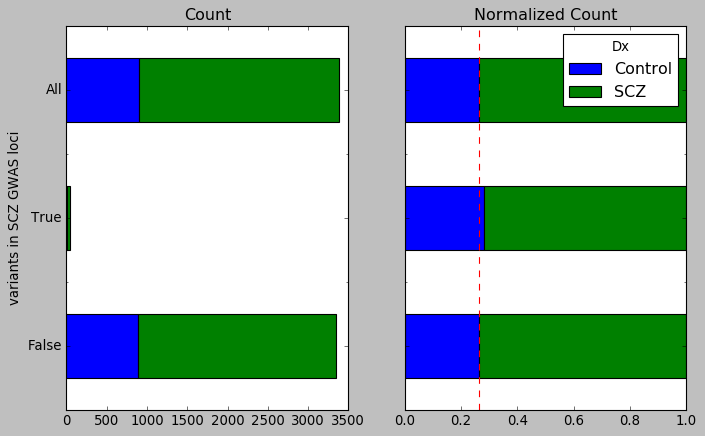

In [22]:
gwas = pd.crosstab(calls['GWASpval'] !=0, calls['Dx'], margins=True)
gwas_norm = pd.crosstab(calls['GWASpval'] !=0, calls['Dx'], margins=True, normalize='index')
fig, ax = simplebar(gwas, gwas_norm)
ax[0].set_ylabel('variants in SCZ GWAS loci')

### Multidimensional view

In [23]:
sel_cols = ['Dx', 'QUAL', 'AF', 'BaseQRankSum', 'DP', 'FS', 'QD', 'ReadPosRankSum', 'SOR', 'VQSLOD', 'szdbCNVcount']
calls1 = preprocessing.preprocess(calls.loc[:, sel_cols], prettify=False, dummify=False)

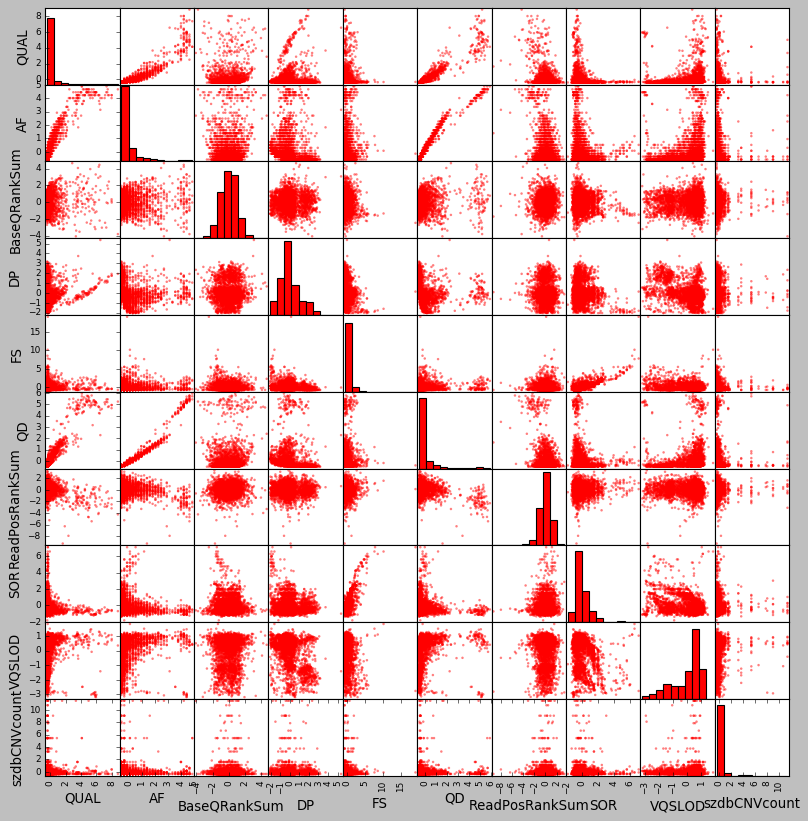

In [24]:
ax = ppl.scatter_matrix(calls1[sel_cols], diagonal='hist', figsize=(12, 12), color='C2', hist_kwds={'color': 'C2'})

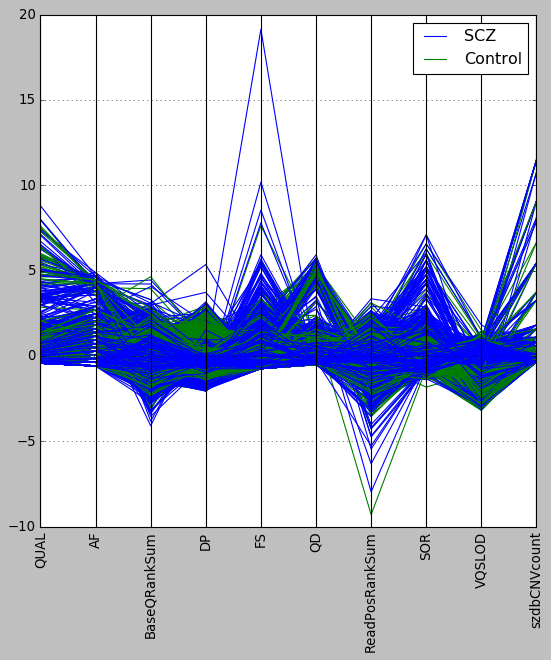

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ppl.parallel_coordinates(calls1, class_column='Dx', ax=ax, color=['C0', 'C1'])
#ppl.ordinates(df, class_column='Dx', ax=ax, color=['blue', 'orange'])
_ = plt.xticks(rotation=90)

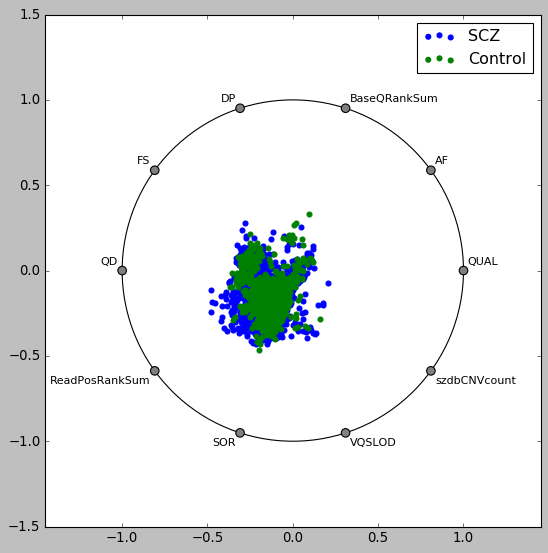

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
ppl.radviz(calls1, class_column='Dx', ax=ax, color=['C0', 'C1'])

In [27]:
%connect_info

{
  "shell_port": 45111,
  "iopub_port": 52317,
  "stdin_port": 51777,
  "control_port": 38867,
  "hb_port": 37143,
  "ip": "127.0.0.1",
  "key": "cee54411-ad62a14ba5a0ea6fc5c4a24d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-c601ec44-756c-425a-ba1d-7eb914cb4105.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
